In [1]:
import numpy as np
import scipy.stats as si

def black_scholes(S, K, T, r, sigma, option_type="call"):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == "call":
        price = S * si.norm.cdf(d1) - K * np.exp(-r * T) * si.norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * si.norm.cdf(-d2) - S * si.norm.cdf(-d1)
    
    return price

def binomial_tree(S, K, T, r, sigma, N=100, option_type="call", american=False):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    
    prices = np.zeros((N + 1, N + 1))
    values = np.zeros((N + 1, N + 1))
    
    for i in range(N + 1):
        prices[i, N] = S * (u ** (N - i)) * (d ** i)
        values[i, N] = max(0, (prices[i, N] - K) if option_type == "call" else (K - prices[i, N]))
    
    for j in range(N - 1, -1, -1):
        for i in range(j + 1):
            values[i, j] = np.exp(-r * dt) * (p * values[i, j + 1] + (1 - p) * values[i + 1, j + 1])
            if american:
                values[i, j] = max(values[i, j], (prices[i, j] - K) if option_type == "call" else (K - prices[i, j]))
    
    return values[0, 0]

def monte_carlo(S, K, T, r, sigma, simulations=10000, option_type="call"):
    np.random.seed(42)
    Z = np.random.standard_normal(simulations)
    ST = S * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * Z)
    
    if option_type == "call":
        payoff = np.maximum(ST - K, 0)
    else:
        payoff = np.maximum(K - ST, 0)
    
    return np.exp(-r * T) * np.mean(payoff)

def greeks(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    delta = si.norm.cdf(d1)
    gamma = si.norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * si.norm.pdf(d1) * np.sqrt(T)
    theta = -(S * si.norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * si.norm.cdf(d2)
    rho = K * T * np.exp(-r * T) * si.norm.cdf(d2)
    
    return {"Delta": delta, "Gamma": gamma, "Vega": vega, "Theta": theta, "Rho": rho}

# Example Usage
S = 100  # Spot price
K = 100  # Strike price
T = 1    # Time to maturity (in years)
r = 0.05 # Risk-free rate
sigma = 0.2 # Volatility

print("Black-Scholes Call Price:", black_scholes(S, K, T, r, sigma, "call"))
print("Binomial Tree American Call Price:", binomial_tree(S, K, T, r, sigma, N=100, option_type="call", american=True))
print("Monte Carlo Call Price:", monte_carlo(S, K, T, r, sigma, simulations=10000, option_type="call"))
print("Greeks:", greeks(S, K, T, r, sigma))


Black-Scholes Call Price: 10.450583572185565
Binomial Tree American Call Price: 10.430611662249113
Monte Carlo Call Price: 10.450169921134655
Greeks: {'Delta': 0.6368306511756191, 'Gamma': 0.018762017345846895, 'Vega': 37.52403469169379, 'Theta': -6.414027546438197, 'Rho': 53.232481545376345}


Black-Scholes Call Price: 10.450583572185565
Binomial Tree Call Price: 10.430611662249113
Asian Call Option Price: 5.713201547276918
Barrier Knock-In Call Price: 23.45253514498533


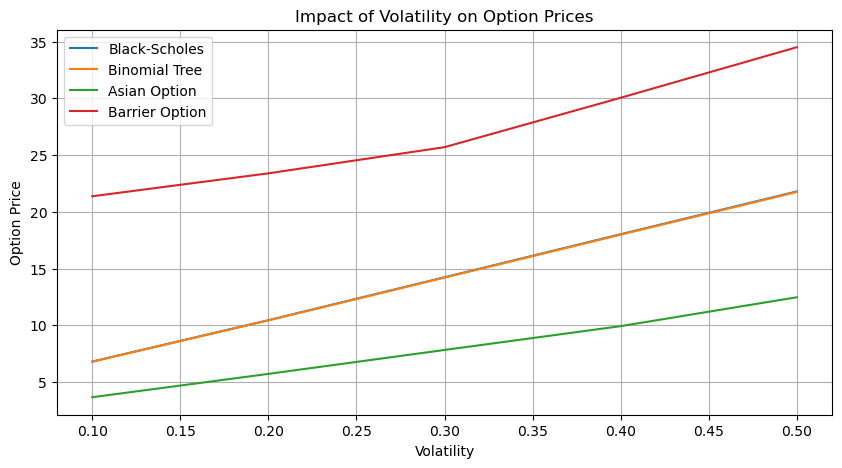

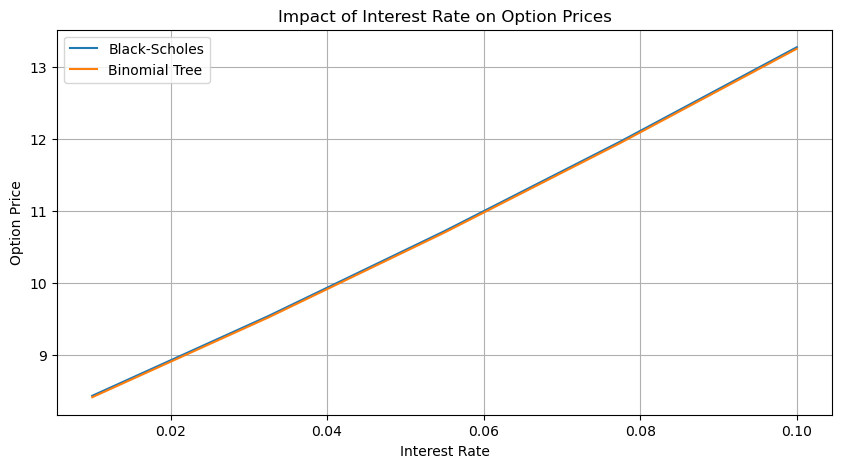

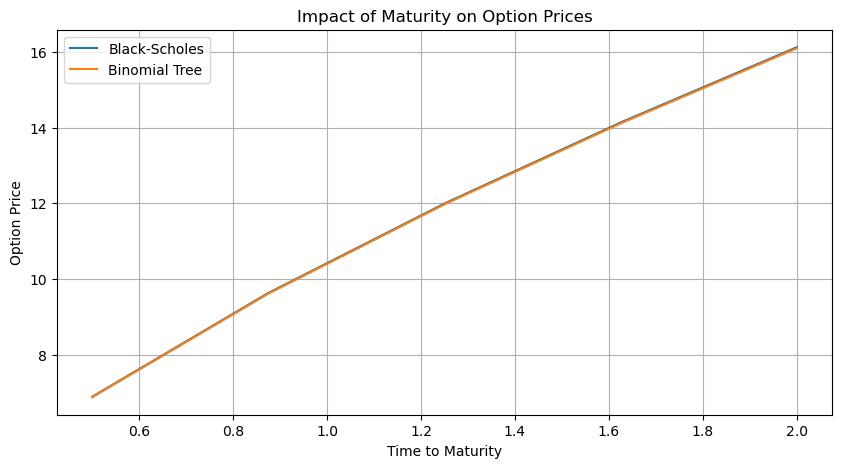

In [3]:
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt

# === 1️⃣ BLACK-SCHOLES MODEL (For European Options) === #
def black_scholes(S, K, T, r, sigma, option_type="call"):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "call":
        price = S * si.norm.cdf(d1) - K * np.exp(-r * T) * si.norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * si.norm.cdf(-d2) - S * si.norm.cdf(-d1)

    return price

# === 2️⃣ BINOMIAL TREE MODEL (For American Options) === #
def binomial_tree(S, K, T, r, sigma, steps=100, option_type="call"):
    dt = T / steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    price_tree = np.zeros((steps + 1, steps + 1))
    for j in range(steps + 1):
        price_tree[j, steps] = max(0, (S * (u**j) * (d**(steps - j)) - K) if option_type == "call" else (K - S * (u**j) * (d**(steps - j))))

    for i in range(steps - 1, -1, -1):
        for j in range(i + 1):
            price_tree[j, i] = np.exp(-r * dt) * (p * price_tree[j + 1, i + 1] + (1 - p) * price_tree[j, i + 1])

    return price_tree[0, 0]

# === 3️⃣ MONTE CARLO SIMULATION (For Asian Options) === #
def monte_carlo_asian(S, K, T, r, sigma, simulations=10000, steps=100, option_type="call"):
    dt = T / steps
    payoffs = []

    for _ in range(simulations):
        path = [S]
        for _ in range(steps):
            Z = np.random.standard_normal()
            S_t = path[-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
            path.append(S_t)
        
        average_price = np.mean(path)  
        payoffs.append(max(average_price - K, 0) if option_type == "call" else max(K - average_price, 0))

    return np.exp(-r * T) * np.mean(payoffs)

# === 4️⃣ MONTE CARLO SIMULATION (For Barrier Options) === #
def monte_carlo_barrier(S, K, T, r, sigma, barrier, simulations=10000, steps=100, option_type="call", barrier_type="knock-in"):
    dt = T / steps
    payoffs = []

    for _ in range(simulations):
        path = [S]
        barrier_reached = False

        for _ in range(steps):
            Z = np.random.standard_normal()
            S_t = path[-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
            path.append(S_t)

            if (option_type == "call" and S_t >= barrier) or (option_type == "put" and S_t <= barrier):
                barrier_reached = True

        final_price = path[-1]
        if barrier_type == "knock-in" and not barrier_reached:
            continue
        if barrier_type == "knock-out" and barrier_reached:
            continue

        payoffs.append(max(final_price - K, 0) if option_type == "call" else max(K - final_price, 0))

    return np.exp(-r * T) * np.mean(payoffs) if payoffs else 0

# === 5️⃣ ANALYZING IMPACT OF VOLATILITY, INTEREST RATE, AND MATURITY === #
def analyze_parameter_impact(S, K, T, r, sigma):
    volatilities = np.linspace(0.1, 0.5, 5)  
    interest_rates = np.linspace(0.01, 0.1, 5)  
    maturities = np.linspace(0.5, 2, 5)  

    bs_prices = [black_scholes(S, K, T, r, vol) for vol in volatilities]
    binomial_prices = [binomial_tree(S, K, T, r, vol) for vol in volatilities]
    asian_prices = [monte_carlo_asian(S, K, T, r, vol) for vol in volatilities]
    barrier_prices = [monte_carlo_barrier(S, K, T, r, vol, barrier=120) for vol in volatilities]

    # Plot impact of volatility
    plt.figure(figsize=(10, 5))
    plt.plot(volatilities, bs_prices, label="Black-Scholes")
    plt.plot(volatilities, binomial_prices, label="Binomial Tree")
    plt.plot(volatilities, asian_prices, label="Asian Option")
    plt.plot(volatilities, barrier_prices, label="Barrier Option")
    plt.xlabel("Volatility")
    plt.ylabel("Option Price")
    plt.title("Impact of Volatility on Option Prices")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot impact of interest rates
    bs_prices_r = [black_scholes(S, K, T, rate, sigma) for rate in interest_rates]
    binomial_prices_r = [binomial_tree(S, K, T, rate, sigma) for rate in interest_rates]

    plt.figure(figsize=(10, 5))
    plt.plot(interest_rates, bs_prices_r, label="Black-Scholes")
    plt.plot(interest_rates, binomial_prices_r, label="Binomial Tree")
    plt.xlabel("Interest Rate")
    plt.ylabel("Option Price")
    plt.title("Impact of Interest Rate on Option Prices")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot impact of time to maturity
    bs_prices_t = [black_scholes(S, K, mat, r, sigma) for mat in maturities]
    binomial_prices_t = [binomial_tree(S, K, mat, r, sigma) for mat in maturities]

    plt.figure(figsize=(10, 5))
    plt.plot(maturities, bs_prices_t, label="Black-Scholes")
    plt.plot(maturities, binomial_prices_t, label="Binomial Tree")
    plt.xlabel("Time to Maturity")
    plt.ylabel("Option Price")
    plt.title("Impact of Maturity on Option Prices")
    plt.legend()
    plt.grid(True)
    plt.show()

# === 6️⃣ TESTING THE IMPLEMENTATION === #
S, K, T, r, sigma = 100, 100, 1, 0.05, 0.2  

print("Black-Scholes Call Price:", black_scholes(S, K, T, r, sigma))
print("Binomial Tree Call Price:", binomial_tree(S, K, T, r, sigma))
print("Asian Call Option Price:", monte_carlo_asian(S, K, T, r, sigma))
print("Barrier Knock-In Call Price:", monte_carlo_barrier(S, K, T, r, sigma, barrier=120, barrier_type="knock-in"))

analyze_parameter_impact(S, K, T, r, sigma)  # Graphical Analysis
